In [1]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
## Create data
# Create weight and bias
weight = 0.5
bias = 0.2

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels) (y = weight * X + bias)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.2000],
         [0.2100],
         [0.2200],
         [0.2300],
         [0.2400],
         [0.2500],
         [0.2600],
         [0.2700],
         [0.2800],
         [0.2900]]))

In [4]:
# Split data into training and test sets.
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
# Create a function for displaying predictions
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

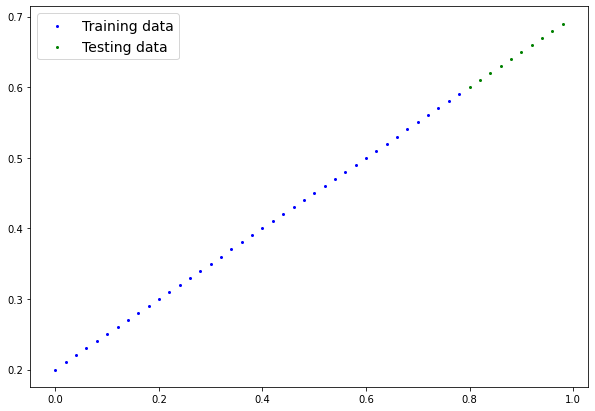

In [7]:
# Visualize
plot_predictions(X_train, y_train, X_test, y_test)

In [8]:
## Build a PyTorch linear model
# Subclass nn.Module to make our model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model = LinearRegressionModel()
model, model.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [10]:
## Training
# Build a training and testing loop

# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=le

In [11]:
# Create an optimization loop in PyTorch
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.7331780195236206 | MAE Test Loss: 0.8519762754440308 
Epoch: 10 | MAE Train Loss: 0.6179680824279785 | MAE Test Loss: 0.7172663807868958 
Epoch: 20 | MAE Train Loss: 0.5027582049369812 | MAE Test Loss: 0.5825566053390503 
Epoch: 30 | MAE Train Loss: 0.3875483274459839 | MAE Test Loss: 0.44784674048423767 
Epoch: 40 | MAE Train Loss: 0.2723384499549866 | MAE Test Loss: 0.31313690543174744 
Epoch: 50 | MAE Train Loss: 0.15712858736515045 | MAE Test Loss: 0.178427055478096 
Epoch: 60 | MAE Train Loss: 0.04191867634654045 | MAE Test Loss: 0.04371718689799309 
Epoch: 70 | MAE Train Loss: 0.004279922228306532 | MAE Test Loss: 0.014590626582503319 
Epoch: 80 | MAE Train Loss: 0.004279922228306532 | MAE Test Loss: 0.014590626582503319 
Epoch: 90 | MAE Train Loss: 0.004279922228306532 | MAE Test Loss: 0.014590626582503319 


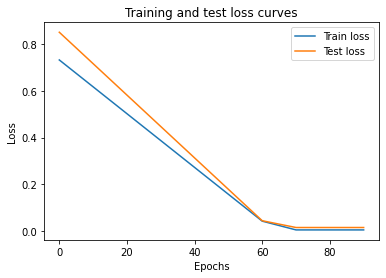

In [12]:
# Plot the loss decline over epochs
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [14]:
# Find trained model's learned parameters
print("The model learned the following values for weights and bias:")
print(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.5108]])), ('linear_layer.bias', tensor([0.1915]))])

And the original values for weights and bias are:
weights: 0.5, bias: 0.2


In [15]:
## Making predictions with a trained PyTorch model
# 1. Set the model in evaluation mode
model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  y_preds = model(X_test)
y_preds

tensor([[0.6001],
        [0.6104],
        [0.6206],
        [0.6308],
        [0.6410],
        [0.6512],
        [0.6614],
        [0.6717],
        [0.6819],
        [0.6921]])

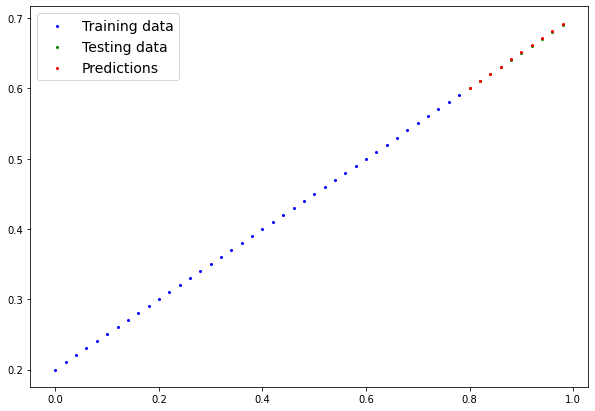

In [16]:
# Examine how our fit look like ?
plot_predictions(predictions=y_preds)

In [23]:
## Saving a PyTorch model
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model.pth


In [24]:
## Loading a saved PyTorch model
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [25]:
# 1. Put the loaded model into evaluation mode
loaded_model.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test) # perform a forward pass on the test data with the loaded model

In [26]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])